In [1]:
import requests
def sendMessage2(msg):
  request = 'https://api.telegram.org/bot1369312376:AAHbUrfa0wrkCUCpQXldwcW7s0jC7t9solA/sendmessage?chat_id=-477466040&text='+ msg
  r = requests.post(request)

In [1]:
import requests
from io import BytesIO
from PIL import Image
def sendMessage(img,msg):
    bio = BytesIO()
    bio.name = 'image.jpeg'
    img = Image.fromarray(img)
    img.save(bio, 'JPEG')
    bio.seek(0)
    url = "https://api.telegram.org/bot1369312376:AAHbUrfa0wrkCUCpQXldwcW7s0jC7t9solA/sendphoto";
    files = {'photo': bio}
    data = {'chat_id' : "-477466040", 'caption': msg}
    r= requests.post(url, files=files, data=data)

In [90]:
import matplotlib.pyplot as plt
def imshow(image, ax=None, title=None):
    if ax is None:
        fig, ax = plt.subplots()
    
    # PyTorch tensors assume the color channel is the first dimension
    # but matplotlib assumes is the third dimension
    image = image.transpose((1, 2, 0))
    
    # Undo preprocessing
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    image = std * image + mean
    
    if title is not None:
        ax.set_title(title)
    
    # Image needs to be clipped between 0 and 1 or it looks like noise when displayed
    image = np.clip(image, 0, 1)
    
    ax.imshow(image)
    
    return ax

In [2]:
import numpy as np
import cv2

import torch
from torch import nn, optim
import torch.nn.functional as F
from torchvision import datasets, transforms, models

In [3]:
from collections import OrderedDict

def load_checkpoint(filepath):
    
    checkpoint = torch.load(filepath)
    
    if checkpoint['arch'] == 'alexnet':
        
        model = models.alexnet(pretrained=True)
        
        for param in model.parameters():
            param.requires_grad = False
    else:
        print("Architecture not recognized.")
    
    model.class_to_idx = checkpoint['class_to_idx']
    
    classifier = nn.Sequential(OrderedDict([('fc1', nn.Linear(9216, 5000)),
                                            ('relu', nn.ReLU()),
                                            ('drop', nn.Dropout(p=0.5)),
                                            ('fc2', nn.Linear(5000, 7)),
                                            ('output', nn.LogSoftmax(dim=1))]))

    model.classifier = classifier
    
    model.load_state_dict(checkpoint['model_state_dict'])
    
    return model

In [4]:
model = load_checkpoint('25.pth')

In [101]:
from numpy import *
from PIL import Image

red_lower_threshold = 150
green_blue_diff_threshold = 50

def grayscale(picture):
    for i in range(0, len(picture[0])):
        for j in range(0, len(picture[0][0])):

            red = picture[0][i][j]
            green = picture[1][i][j]
            blue = picture[2][i][j]

            if (red > red_lower_threshold and abs(green - blue) < green_blue_diff_threshold):
                picture[0][i][j] = red
                picture[1][i][j] = green
                picture[2][i][j] = blue
            else:
                avg = (red + green + blue) / 3
                picture[0][i][j] = red
                picture[1][i][j] = red
                picture[2][i][j] = red

    return picture

In [91]:
from PIL import Image

def process_image(image_path):
    pil_image = Image.fromarray(image_path) 
    
    # Resize
    if pil_image.size[0] > pil_image.size[1]:
        pil_image.thumbnail((5000, 256))
    else:
        pil_image.thumbnail((256, 5000))
        
    # Crop
    left_margin = (pil_image.width-224)/2
    bottom_margin = (pil_image.height-224)/2
    right_margin = left_margin + 224
    top_margin = bottom_margin + 224
    
    pil_image = pil_image.crop((left_margin, bottom_margin, right_margin, top_margin))
    
    # Normalize
    np_image = np.array(pil_image)/255
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    np_image = (np_image - mean) / std
    
    # PyTorch expects the color channel to be the first dimension but it's the third dimension in the PIL image and Numpy array
    # Color channel needs to be first; retain the order of the other two dimensions.
    np_image = np_image.transpose((2, 0, 1))
   
    np_image = grayscale(np_image)
    imshow(np_image)
    return np_image

In [6]:
def predict(image_path, model, topk=5):

    image = process_image(image_path)
    
    image = torch.from_numpy(image).type(torch.cuda.FloatTensor)
    
    # Returns a new tensor with a dimension of size one inserted at the specified position.
    image = image.unsqueeze(0)
    model.cuda()
    output = model.forward(image)
    
    probabilities = torch.exp(output)
    
    # Probabilities and the indices of those probabilities corresponding to the classes
    top_probabilities, top_indices = probabilities.topk(topk)
    
    # Convert to lists
    top_probabilities = top_probabilities.detach().type(torch.FloatTensor).numpy().tolist()[0] 
    top_indices = top_indices.detach().type(torch.FloatTensor).numpy().tolist()[0] 
    
    # Convert topk_indices to the actual class labels using class_to_idx
    # Invert the dictionary so you get a mapping from index to class.
    
    idx_to_class = {value: key for key, value in model.class_to_idx.items()}
    
    top_classes = [idx_to_class[index] for index in top_indices]
    
    return top_probabilities, top_classes

In [7]:
import traitlets
from IPython.display import display
import ipywidgets.widgets as widgets
from jetbot import Camera, bgr8_to_jpeg

camera = Camera.instance(width=224, height=224)
image = widgets.Image(format='jpeg', width=224, height=224)

camera_link = traitlets.dlink((camera, 'value'), (image, 'value'), transform=bgr8_to_jpeg)

In [8]:
from jetbot import Robot

robot = Robot()

robot.left_motor.alpha =2.5
robot.right_motor.alpha = 1.5

In [9]:
display(widgets.HBox([image]))

In [128]:
import torch.nn.functional as F
import time
last = -1

import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

import cv2



def update(change):
    global last, robot
    x = change['new'] 
    
    probs, classes = predict(x, model)
    #if probs[0] > 0.9:
        #if last != classes[0]:
    last = classes[0]
    clase = ''
    if last == "1":
        clase = 'alto'
    elif last == "2":
        clase = 'doblar a la izquierda'
    elif last == "3":
        clase = 'doblar a la derecha'
    elif last == "4":
        clase = 'ceda'
    elif last == "5":
        clase = 'limite de velocidad'
    elif last == "6":
        clase = 'final'
    elif last == "7":
        clase = 'inicio'
    msg = "Hola soy Anthony! Me parece que he visualizado una señal de " + clase + "."
    print(f'{clase} con {probs[0]}')

    sendMessage(x, msg)
    """
    if prob_blocked < 0.5:
        robot.forward(0.25) #20
    else:
        robot.left(0.29) #19
    """
    time.sleep(0.001)
    #time.sleep(1)

doblar a la derecha con 0.9884486198425293


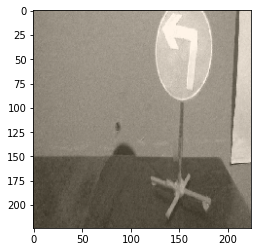

In [163]:
update({'new': camera.value})  # we call the function once to intialize
#camera.observe(update, names='value')

In [ ]:
import time

camera.unobserve(update, names='value')

time.sleep(0.1)  # add a small sleep to make sure frames have finished processing

robot.stop()